In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
from PIL import Image
import numpy as np

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:

batch_size = 128
epochs = 15
learning_rate = 0.001
image_size = (224, 224)

In [ ]:

train_image_dir = "../data/images/train"
train_label_file = "../data/attribute_matrix_train.txt"
test_image_dir = "../data/images/test"
test_label_file = "../data/attribute_matrix_test.txt"



transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def process_group_labels(group_labels):

    found_one = False
    processed_labels = []
    
    for idx, value in enumerate(group_labels):
        if value == 1 and not found_one:
            processed_labels.append(1)
            found_one = True
        else:
            processed_labels.append(0)
    
    return processed_labels


In [ ]:


class GroupedImageDataset(Dataset):
    def __init__(self, image_dir, label_file, attribute_groups, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True))
        raw_labels = np.loadtxt(label_file, dtype=int)
        self.attribute_groups = attribute_groups
        self.transform = transform
        #prepare grouped labels
        self.labels = [
             {group: torch.tensor(process_group_labels([label[idx] for idx in indices]), dtype=torch.long).argmax()  
              for group, indices in attribute_groups.items()}
             for label in raw_labels
        ]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

In [ ]:

class ResNetGroupedMultiClass(nn.Module):
    def __init__(self, attribute_groups):
        super(ResNetGroupedMultiClass, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.ModuleDict({
            group_name: nn.Linear(in_features, len(indices))
            for group_name, indices in attribute_groups.items()
        })

    def forward(self, x):
        features = self.resnet(x)
        features = self.dropout(features)
        outputs = {
            group_name: classifier(features)
            for group_name, classifier in self.fc.items()
        }
        return outputs

In [8]:
# Attribute Groups
attribute_groups = {
    "has_bill_shape": list(range(0, 9)),
    "has_wing_color": list(range(9, 24)),
    "has_upperparts_color": list(range(24, 39)),
    "has_underparts_color": list(range(39, 54)),
    "has_breast_pattern": list(range(54, 58)),
    "has_back_color": list(range(58, 73)),
    "has_tail_shape": list(range(73, 79)),
    "has_upper_tail_color": list(range(79, 94)),
    "has_head_pattern": list(range(94, 105)),
    "has_breast_color": list(range(105, 120)),
    "has_throat_color": list(range(120, 135)),
    "has_eye_color": list(range(135, 149)),
    "has_bill_length": list(range(149, 152)),
    "has_forehead_color": list(range(152, 167)),
    "has_under_tail_color": list(range(167, 182)),
    "has_nape_color": list(range(182, 197)),
    "has_belly_color": list(range(197, 212)),
    "has_wing_shape": list(range(212, 217)),
    "has_size": list(range(217, 222)),
    "has_shape": list(range(222, 236)),
    "has_back_pattern": list(range(236, 240)),
    "has_tail_pattern": list(range(240, 244)),
    "has_belly_pattern": list(range(244, 248)),
    "has_primary_color": list(range(248, 263)),
    "has_leg_color": list(range(263, 278)),
    "has_bill_color": list(range(278, 293)),
    "has_crown_color": list(range(293, 308)),
    "has_wing_pattern": list(range(308, 312)),
}

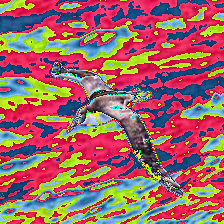

In [ ]:
train_dataset = GroupedImageDataset(train_image_dir, train_label_file, attribute_groups, transform)
test_dataset = GroupedImageDataset(test_image_dir, test_label_file, attribute_groups, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#train_dataset.labels[0]
for test_images, test_labels in test_loader:  
    sample_image = test_images   
    sample_label = test_labels
    break
trans = transforms.ToPILImage()
out = trans(sample_image[0])
out.show()

In [14]:

criterion = {
    group: nn.CrossEntropyLoss()
    for group in attribute_groups.keys()
}

In [74]:

model = ResNetGroupedMultiClass(attribute_groups).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [76]:
def train_grouped_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct_predictions = {group: 0 for group in attribute_groups.keys()}
        total_samples = {group: 0 for group in attribute_groups.keys()}

        for images, labels in train_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}

            optimizer.zero_grad()
            outputs = model(images)
            loss = sum(criterion[group](outputs[group], labels[group]) for group in outputs)/len(outputs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            for group in outputs:
                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)

        for group in correct_predictions:
            acc = correct_predictions[group]/total_samples[group]
            print(f"accuracy for group {group}: {acc}")
        torch.save(model.state_dict(), '../models/grouped_attribute_predictor.pth')
        torch.save(optimizer.state_dict(), "../models/grouped_attribute_predictor_optimizer.pth")
        # Calculate epoch accuracy
        total_accuracy = sum(correct_predictions[group] for group in correct_predictions) / sum(total_samples[group] for group in total_samples)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Total Accuracy: {total_accuracy:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_grouped_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = {group: 0 for group in attribute_groups.keys()}
    total_samples = {group: 0 for group in attribute_groups.keys()}
    all_preds, all_labels = {group: [] for group in attribute_groups.keys()}, {group: [] for group in attribute_groups.keys()}

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)

            for group in outputs:
                loss = criterion[group](outputs[group], labels[group])
                total_loss += loss.item()

                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)

                all_preds[group].extend(preds.cpu().numpy())
                all_labels[group].extend(labels[group].cpu().numpy())

    for group in attribute_groups.keys():
        acc = correct_predictions[group] / total_samples[group]
        f1 = f1_score(all_labels[group], all_preds[group], average="macro")
        precision = precision_score(all_labels[group], all_preds[group], average="macro")
        recall = recall_score(all_labels[group], all_preds[group], average="macro")

        print(f"Group {group} - Accuracy: {acc:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    all_preds_flat = np.concatenate(list(all_preds.values()))
    all_labels_flat = np.concatenate(list(all_labels.values()))

    total_accuracy = accuracy_score(all_labels_flat, all_preds_flat)
    total_f1 = f1_score(all_labels_flat, all_preds_flat, average="macro")
    total_precision = precision_score(all_labels_flat, all_preds_flat, average="macro")
    total_recall = recall_score(all_labels_flat, all_preds_flat, average="macro")

    print(f"Total Loss: {total_loss/28:.4f}, Total Accuracy: {total_accuracy:.4f}, "
          f"Total F1-Score: {total_f1:.4f}, Total Precision: {total_precision:.4f}, Total Recall: {total_recall:.4f}")


In [78]:
train_grouped_model(model, train_loader, criterion, optimizer, epochs=epochs)


accuracy for group has_bill_shape: 0.3735402068735402
accuracy for group has_wing_color: 0.3725392058725392
accuracy for group has_upperparts_color: 0.3395061728395062
accuracy for group has_underparts_color: 0.3221554888221555
accuracy for group has_breast_pattern: 0.6286286286286287
accuracy for group has_back_color: 0.3233233233233233
accuracy for group has_tail_shape: 0.3228228228228228
accuracy for group has_upper_tail_color: 0.3688688688688689
accuracy for group has_head_pattern: 0.23823823823823823
accuracy for group has_breast_color: 0.32048715382048715
accuracy for group has_throat_color: 0.3495161828495162
accuracy for group has_eye_color: 0.7857857857857858
accuracy for group has_bill_length: 0.6161161161161162
accuracy for group has_forehead_color: 0.3365031698365032
accuracy for group has_under_tail_color: 0.3063063063063063
accuracy for group has_nape_color: 0.33249916583249917
accuracy for group has_belly_color: 0.3341675008341675
accuracy for group has_wing_shape: 0.621

In [15]:
evaluate_grouped_model(model, test_loader, criterion)

/home/kaidashova/anaconda3/envs/newBird/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaidashova/anaconda3/envs/newBird/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaidashova/anaconda3/envs/newBird/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Group has_bill_shape - Accuracy: 0.4515, F1-Score: 0.2530, Precision: 0.3705, Recall: 0.2635
Group has_wing_color - Accuracy: 0.3385, F1-Score: 0.1527, Precision: 0.1718, Recall: 0.1566
Group has_upperparts_color - Accuracy: 0.3045, F1-Score: 0.1473, Precision: 0.1886, Recall: 0.1487
Group has_underparts_color - Accuracy: 0.3564, F1-Score: 0.2089, Precision: 0.2128, Recall: 0.2204
Group has_breast_pattern - Accuracy: 0.6367, F1-Score: 0.2793, Precision: 0.3989, Recall: 0.2953
Group has_back_color - Accuracy: 0.3134, F1-Score: 0.1351, Precision: 0.1877, Recall: 0.1386
Group has_tail_shape - Accuracy: 0.2794, F1-Score: 0.1279, Precision: 0.1674, Recall: 0.1856
Group has_upper_tail_color - Accuracy: 0.3887, F1-Score: 0.1045, Precision: 0.1675, Recall: 0.1107
Group has_head_pattern - Accuracy: 0.2411, F1-Score: 0.1058, Precision: 0.1806, Recall: 0.1270
Group has_breast_color - Accuracy: 0.3497, F1-Score: 0.2024, Precision: 0.2237, Recall: 0.2071
Group has_throat_color - Accuracy: 0.3671, F

/home/kaidashova/anaconda3/envs/newBird/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaidashova/anaconda3/envs/newBird/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaidashova/anaconda3/envs/newBird/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

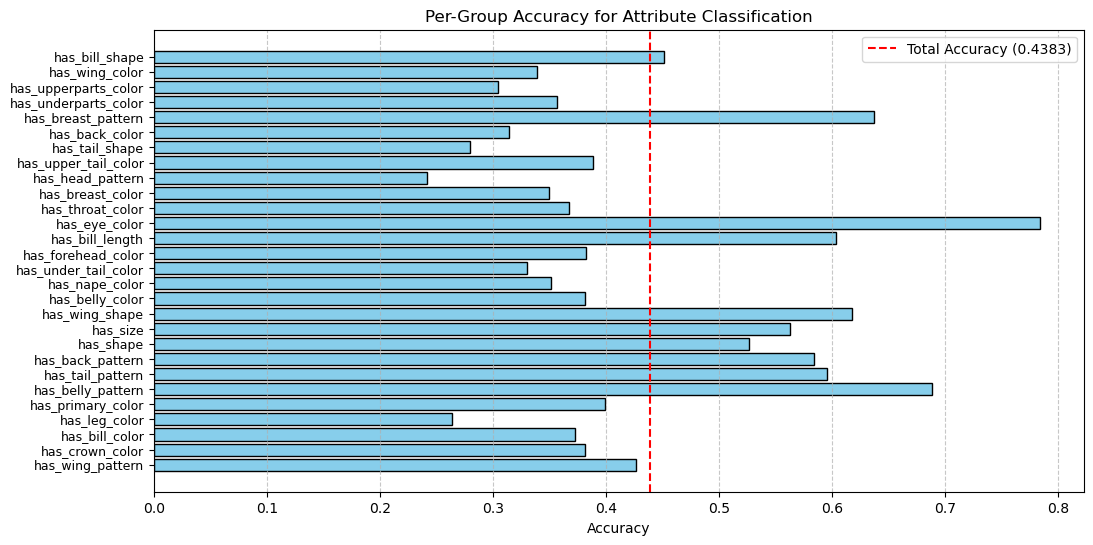

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
attribute_groups = [
    "has_bill_shape", "has_wing_color", "has_upperparts_color", "has_underparts_color",
    "has_breast_pattern", "has_back_color", "has_tail_shape", "has_upper_tail_color",
    "has_head_pattern", "has_breast_color", "has_throat_color", "has_eye_color",
    "has_bill_length", "has_forehead_color", "has_under_tail_color", "has_nape_color",
    "has_belly_color", "has_wing_shape", "has_size", "has_shape",
    "has_back_pattern", "has_tail_pattern", "has_belly_pattern", "has_primary_color",
    "has_leg_color", "has_bill_color", "has_crown_color", "has_wing_pattern"
]

accuracy_values = [
    0.4515, 0.3385, 0.3045, 0.3564, 0.6367, 0.3136, 0.2794, 0.3887,
    0.2413, 0.3497, 0.3671, 0.7834, 0.6032, 0.3819, 0.3302, 0.3512,
    0.3814, 0.6170, 0.5627, 0.5259, 0.5839, 0.5949, 0.6881, 0.3992,
    0.2634, 0.3723, 0.3814, 0.4263
]

fig, ax = plt.subplots(figsize=(12, 6))
y_pos = np.arange(len(attribute_groups))

ax.barh(y_pos, accuracy_values, color="skyblue", edgecolor="black")
ax.set_yticks(y_pos)
ax.set_yticklabels(attribute_groups, fontsize=9)
ax.set_xlabel("Accuracy")
ax.set_title("Per-Group Accuracy for Attribute Classification")
ax.axvline(x=0.4383, color="red", linestyle="--", label="Total Accuracy (0.4383)")

plt.gca().invert_yaxis()  
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, attribute_groups, num_examples=5):
    
    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for i in range(images.size(0)):
                if examples_shown >= num_examples:
                    return
                
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.229) + 0.485  # Rückgängig machen der Normalisierung
                image = np.clip(image, 0, 1)

                true_labels = {group: labels[group][i].item() for group in attribute_groups.keys()}
                
                predicted_labels = {group: torch.argmax(outputs[group], dim=1)[i].item() for group in attribute_groups.keys()}
                
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.axis('off')
                
                plt.title(
                    f"True: {true_labels}\nPredicted: {predicted_labels}",
                    fontsize=8, loc='left', wrap=True
                )
                plt.show()
                
                examples_shown += 1


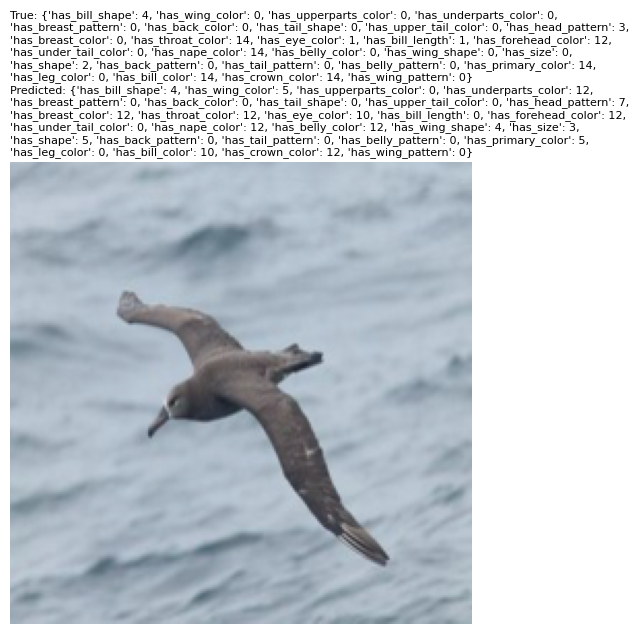

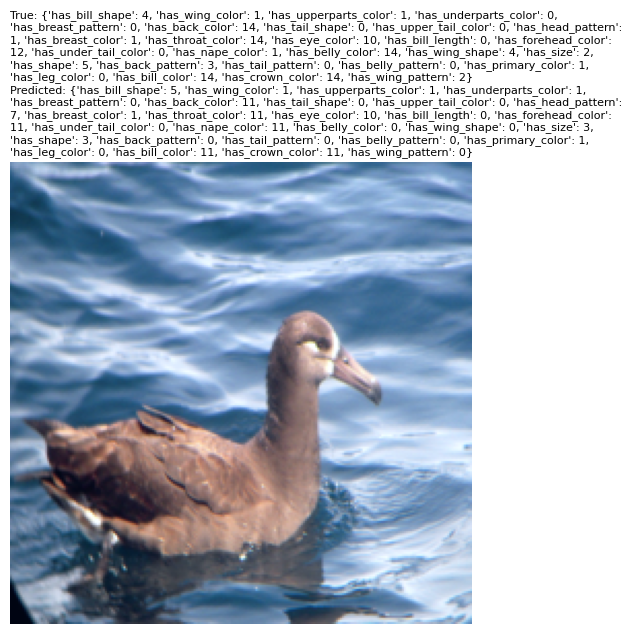

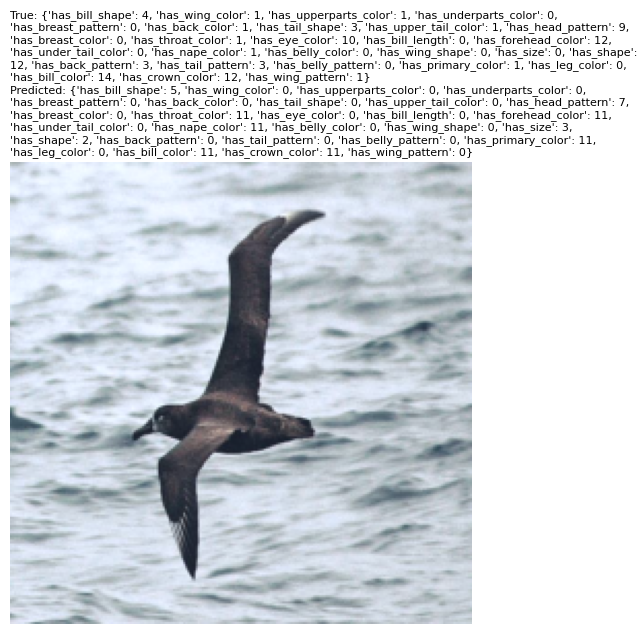

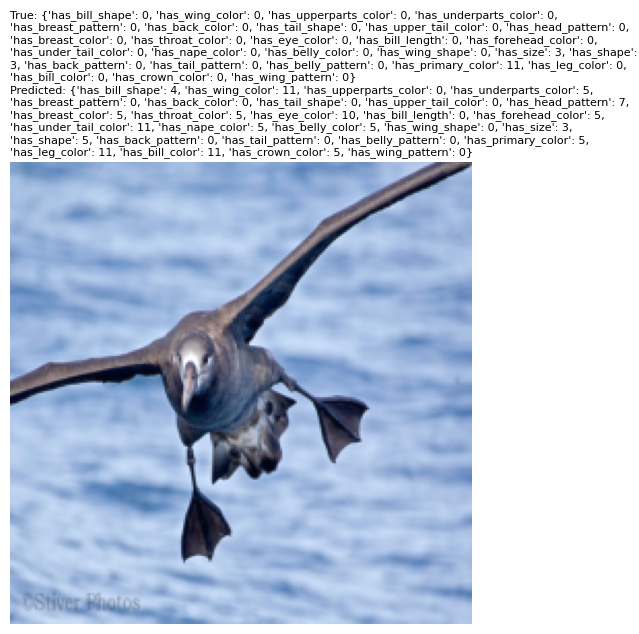

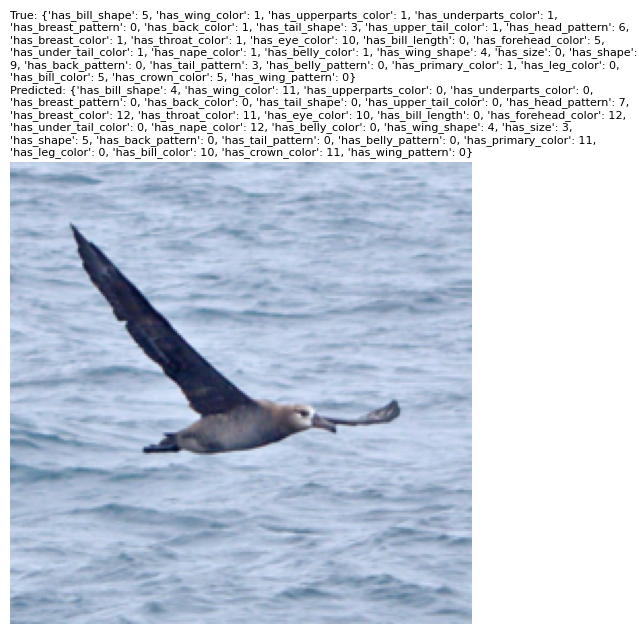

In [81]:
model = ResNetGroupedMultiClass(attribute_groups).to(device)
model.load_state_dict(torch.load("../models/grouped_attribute_predictor.pth"))
visualize_predictions(model, test_loader, attribute_groups, num_examples=5)


In [82]:
def load_attribute_mapping(file_path, attribute_groups):

    attribute_mapping = {group: [] for group in attribute_groups.keys()}
    
    with open(file_path, 'r') as f:
        for line in f:
            index, attribute = line.strip().split(" ", 1)
            index = int(index) - 1  # Nullbasierter Index
            
            attribute_name = attribute.split("::", 1)[-1]
            # Finde, zu welcher Gruppe der Index gehört
            for group, indices in attribute_groups.items():
                if index in indices:
                    attribute_mapping[group].append(attribute_name)
                    break
    
    return attribute_mapping


In [83]:
attribute_mapping = load_attribute_mapping("../data/attributes.txt", attribute_groups)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions_with_names(model, data_loader, attribute_groups, attribute_mapping, num_examples=5):
    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for i in range(images.size(0)):
                if examples_shown >= num_examples:
                    return
                
             
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.229) + 0.485 
                image = np.clip(image, 0, 1)

        
                attributes = attribute_groups
                true_labels = [
                    attribute_mapping[group][labels[group][i].item()]
                    for group in attributes
                ]
                predicted_labels = [
                    attribute_mapping[group][torch.argmax(outputs[group], dim=1)[i].item()]
                    for group in attributes
                ]


                fig, ax = plt.subplots(figsize=(8, 6))
                ax.imshow(image)
                ax.axis('off')


                table_data = [[attr, t, p] for attr, t, p in zip(attributes, true_labels, predicted_labels)]
                table = plt.table(cellText=table_data, colLabels=["Attribute", "True", "Predicted"], 
                                  loc="right", cellLoc="center", colWidths=[0.3, 0.3, 0.3])
                table.auto_set_font_size(False)
                table.set_fontsize(8)
                table.scale(1.2, 1.2) 

                plt.title("True vs. Predicted Labels", fontsize=15, loc='center')
                plt.show()
                
                examples_shown += 1


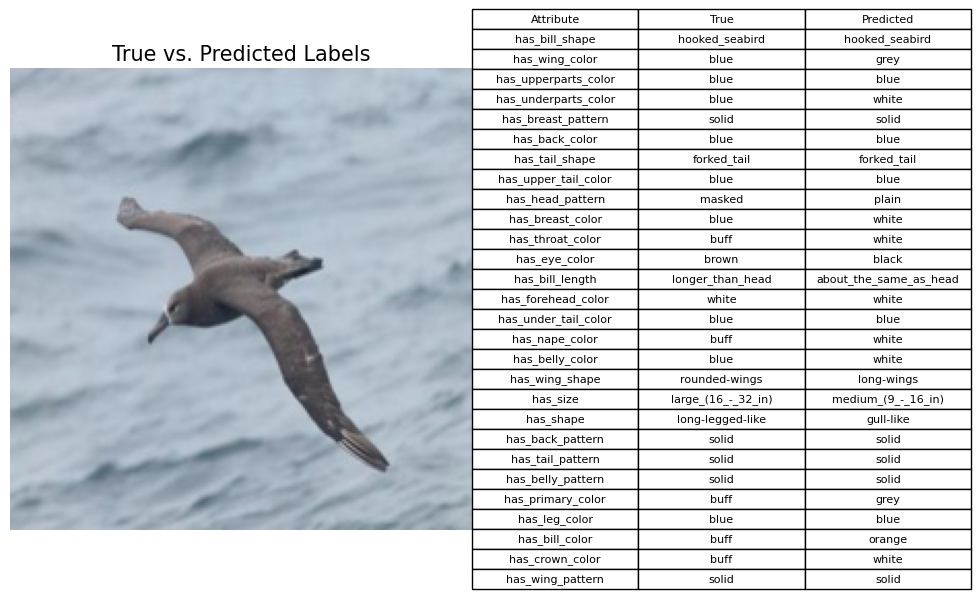

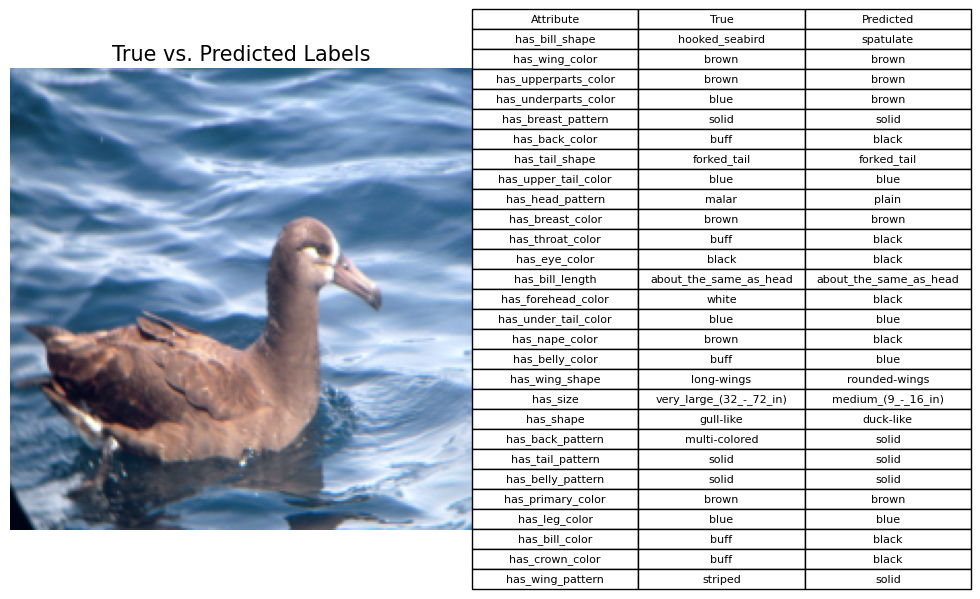

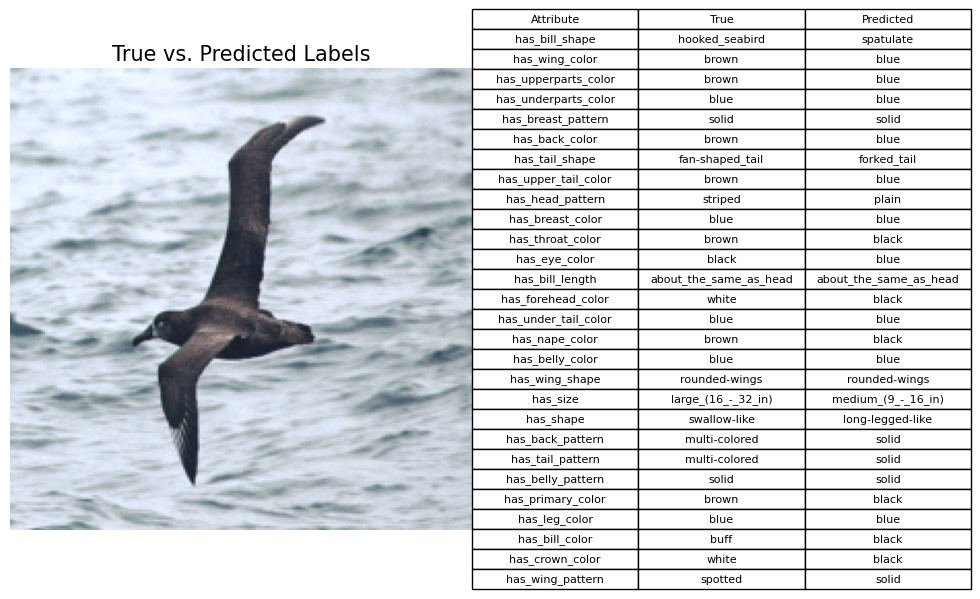

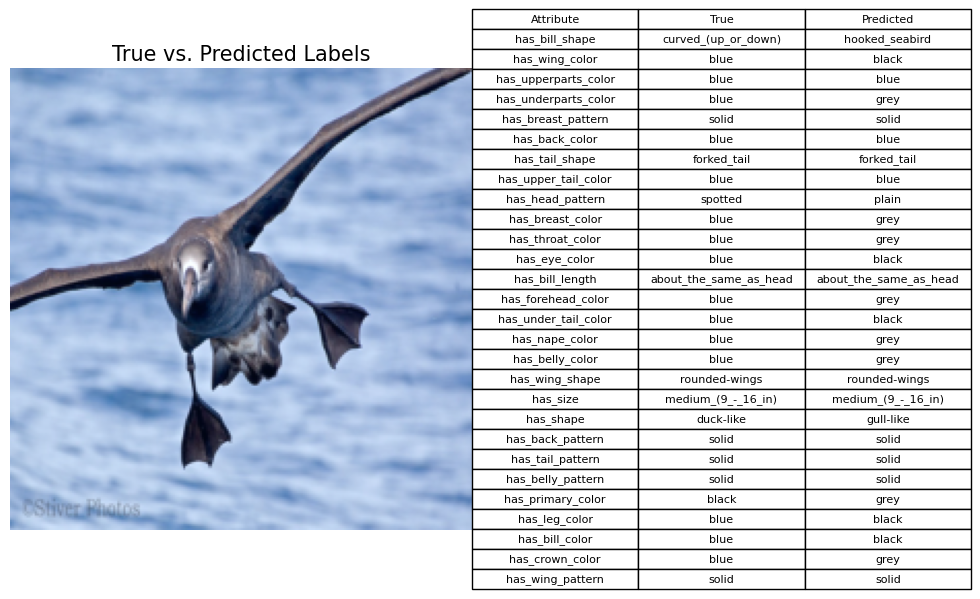

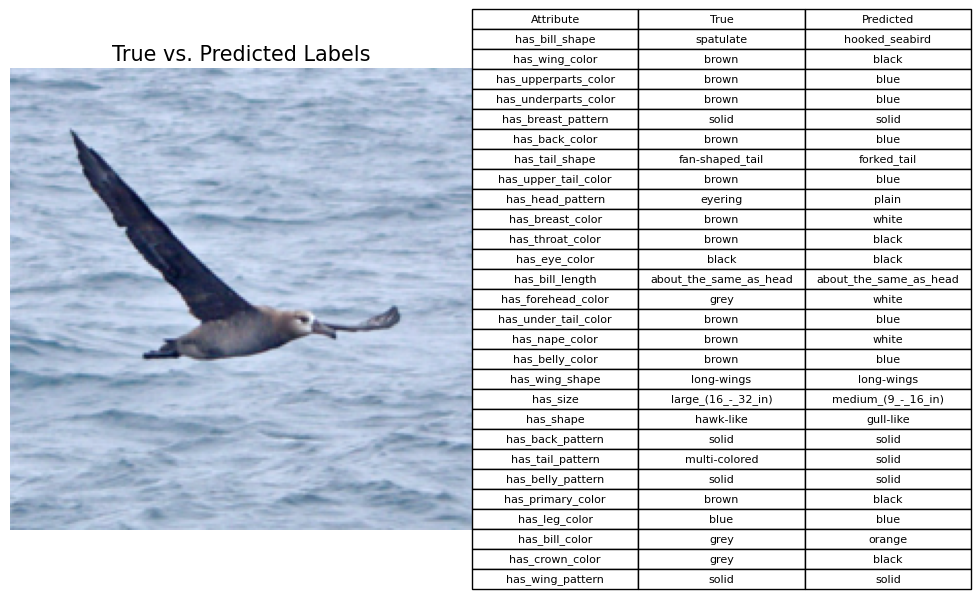

In [105]:
visualize_predictions_with_names(model, test_loader, attribute_groups, attribute_mapping, num_examples=5)